In [2]:
import pyvista as pv
import numpy as np
import rasterio
import gemgis as gg
import numpy as np
import open3d as o3d
from rasterio import features
from rasterio.enums import Resampling
from stl import mesh

from pyproj import Transformer
import json
from urllib.request import urlopen

np.bool = np.bool_


# reader = pv.get_reader("../GEODATA/pne_emprise.tif")
# mesh = reader.read()
# mesh.plot()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [93]:
pne = rasterio.open("../GEODATA/pne_emprise.tif")
upscale_factor = 0.5
band = pne.read(
    out_shape=(pne.count, int(pne.height * upscale_factor), int(pne.width * upscale_factor)),
    resampling=Resampling.bilinear,
)[0]

# scale image transform
transform = pne.transform * pne.transform.scale(
    (pne.width / band.shape[-1]), (pne.height / band.shape[-2])
)
profile = pne.profile.copy()
profile.update({"height": band.shape[0], "width": band.shape[1], "transform": transform})
with rasterio.open("scaled_pne.tif", "w", **profile) as dataset:
    dataset.write(band, 1)
    dataset.close()

In [164]:
pne = rasterio.open("scaled_pne.tif")
band = pne.read(1)

In [165]:
grid = gg.visualization.create_dem_3d(
    dem=band * 0.02, extent=[0, band.shape[1], 0, band.shape[0]], res=1
)
grid.extract_geometry().save("mesh.stl")

c:\Users\jacqu\anaconda3\envs\datascience\lib\site-packages\pyvista\core\utilities\points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


In [170]:
map = mesh.Mesh.from_file("mesh.stl")

In [171]:
query = """
[out:json];
node
  [natural=peak]
  (44.499444,5.818634,45.193651,6.697540);
out;
"""
api_url = "https://overpass-api.de/api/interpreter"
data = json.load(urlopen(api_url, query.encode("utf-8")))
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154")

In [172]:
text_to_display = [
    (node["tags"]["name"], transformer.transform(node["lat"], node["lon"]))
    for node in data["elements"]
    if "name" in node["tags"]
]
text_to_display = [
    (text, (x, y), list(pne.sample([(x, y)], 1))[0][0]) for text, (x, y) in text_to_display
]
text_to_display = [
    (text, (x, y), altitude) for text, (x, y), altitude in text_to_display if altitude > 0
]

In [188]:
coord_lb93 = transformer.transform(44.9307874, 6.3720552)
coord_lb93

(965963.2625717174, 6431411.601440595)

In [192]:
list(pne.sample([coord_lb93], 1))[0][0]

3369.6445

In [193]:
text, (x, y), altitude = "Glacier blanc", coord_lb93, list(pne.sample([coord_lb93], 1))[0][0]
x, y = pne.index(x, y)
altitude = int((altitude / band.max()) * map.max_[2])

In [194]:
x, y, altitude, band.shape

(506, 723, 67, (1567, 1120))

In [195]:
x, y, map.max_

(506, 723, array([1119., 1566.,   81.], dtype=float32))

In [198]:
map.max_, map.min_, band.shape

(array([1119., 1566.,   81.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 (1567, 1120))

In [214]:
from utils import extrude_text

text_3D = extrude_text(
    font_path="../learn3dmodelling_inpython/fonts/Montserrat-VariableFont_wght.ttf",
    text=text,
    extrusion_height=altitude,
)
text_3D.rotate([0, 0, 1], np.deg2rad(90))
text_3D.rotate([1, 0, 0], np.deg2rad(90))
text_3D.rotate([0, 0, 1], np.deg2rad(90))
text_3D.translate(-text_3D.min_)
text_3D.update_min()
wanted_width = map.max_[0] / 15
scale_factor = wanted_width / text_3D.max_[0]
text_3D.x *= scale_factor
text_3D.y *= scale_factor
text_3D.translate([y, map.max_[1] - x, 0])

In [215]:
with_text = mesh.Mesh(
    np.concatenate(
        [
            text_3D.data.copy(),
            map.data.copy(),
        ]
    )
)
with_text.save("testtext.stl")

c:\Users\jacqu\anaconda3\envs\datascience\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (unknown location)

Falling back to a static output.
  warnings.warn(


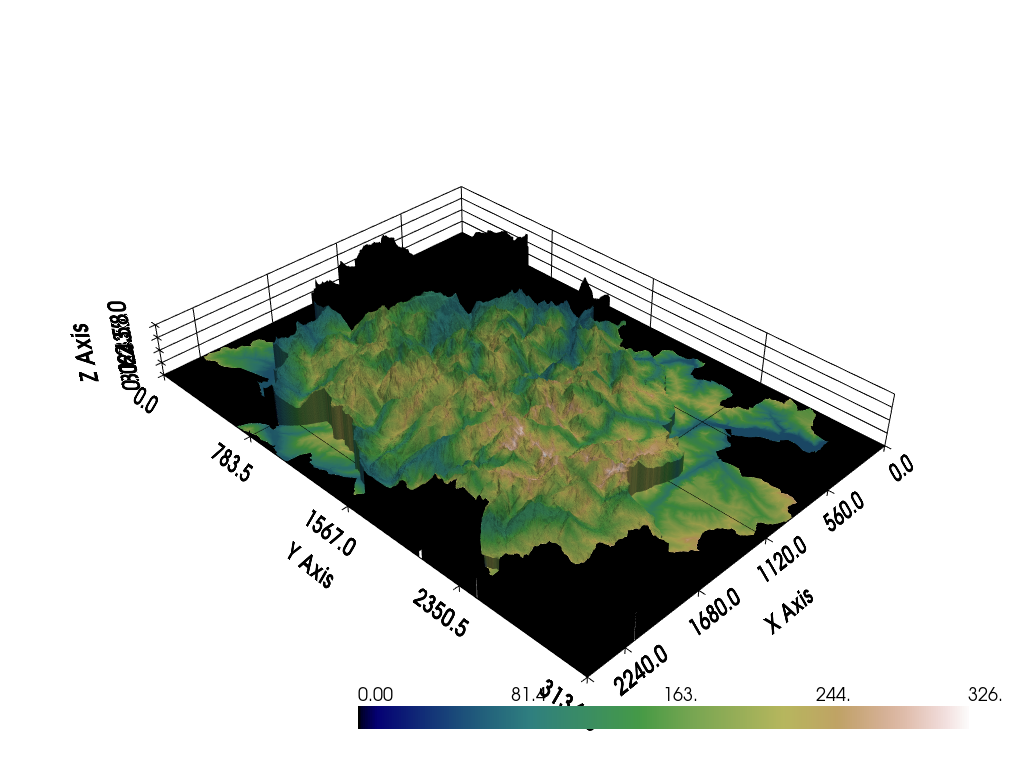

In [18]:
p = pv.Plotter()

p.add_mesh(mesh=grid, scalars=grid["Elevation [m]"], cmap="gist_earth")

p.show_grid(color="black")
p.set_background(color="white")
p.show()

In [52]:
mesh = o3d.t.geometry.TriangleMesh.create_text("Open3D", depth=1).to_legacy()
mesh = o3d.geometry.TriangleMesh.compute_triangle_normals(mesh)
# o3d.visualization.draw([{'name': 'text', 'geometry': mesh}])
o3d.io.write_triangle_mesh("mesh.stl", mesh)  # oh yeah !!!!
# https://github.com/isl-org/Open3D/issues/2012

True

In [ ]:
# https://gemgis.readthedocs.io/en/latest/getting_started/tutorial/10_visualizing_data_with_pyvista.html#Visualizing-the-DEM-with-PyVista
# https://docs.pyvista.org/version/stable/api/readers/_autosummary/pyvista.TIFFReader.html#pyvista.TIFFReader
# https://docs.pyvista.org/version/stable/examples/01-filter/boolean-operations.html